In [1]:
import os
from time import time, sleep

from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision.models.resnet import resnet50
from torchvision.models.mobilenet import mobilenet_v2
from torchvision.models.squeezenet import squeezenet1_0, squeezenet1_1
from torchvision.models.shufflenetv2 import shufflenet_v2_x1_0

if os.path.basename(os.getcwd()) == 'analysis':
    os.chdir('..')
from models.gates_mapper import GatesModulesMapper, NaiveSequentialGatesModulesMapper, ResNetGatesModulesMapper
from models.wrapped_gated_models import ResNet_gating, custom_resnet_from_gated_net, get_wrapped_gating_net_and_criteria
from models.gate_wrapped_module import compute_flop_cost_change, create_conv_channels_dict, create_edge_to_channels_map, dot_string_to_tree_dict
from models.custom_resnet import filter_mapping_from_default_resnet, custom_resnet_50
from external_models.dcp.pruned_resnet import PrunedResnet30, PrunedResnet50, PrunedResnet70


In [2]:
def time_net(net, batch_size=8, run_times=1, measurements=100, lower_limit=0, upper_limit=500000, sleep_seconds=150, return_times=False):
    net.eval()
    total_times=[]
    for r in range(run_times):
        if r > 0:
            sleep(sleep_seconds)
        sample = torch.rand((batch_size,3,224,224)).cuda(1)
        times = []
        for i in range(measurements):
            t = time()
            res = net(sample)
            aa = res[-1,-1].item()
            times.append(time()-t)
        times = np.array(times)
        times = 1000 * times
#         times.sort()
#         times = times[lower_limit:upper_limit]
        total_times.append(times)

    net.train()

    total_times=np.array(total_times)
    
    if return_times:
        return total_times
    else:
        return(total_times.min())
    
#     remove_range=[]
#     std = np.median(total_times.std(1))
#     for i in range(len(total_times)):
#         if total_times[i].mean() - np.median(total_times) > std:
#             remove_range.append(i)
    
#     total_times = np.delete(total_times, remove_range, axis=0)

#     print('25-75 mean, std, min, max (ms) \t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(times.mean(), times.std(), times.min(), times.max()))

#     return total_times

#     return times

In [43]:
resnet_original = resnet50(True)
resnet_original = resnet_original.cuda(1)
times = time_net(resnet_original, batch_size=8, return_times=True, measurements=2000)
# print(time_net(resnet_original))
# for i in range(10):
#     times=time_net(resnet_original)
#     print(np.array(times).min())
#     sleep(20)
# for i in range(10):
#     times.append(time_net(resnet_original))
#     sleep(1.0)
    

In [ ]:
# Resnet50
net_name = 'resnet50'
weight_path = '/media/victoria/d/Training/Eli/resnet50_pre_0_995_w_0_25_gm_0_2_w_0_5_w_1_timing_batch_32/net_e_90'
no_last_conv=False
base_net = resnet50(1000)
custom_net = custom_resnet_from_gated_net(base_net, 'ResNet_gating', weight_path).cuda(1)


In [19]:
# custom resnet 50
net_name = 'custom_resnet_50'
weight_path = '/media/victoria/d/Training/Eli/resnet50_pre_0_995_w_0_25_gm_0_2_timing_batch_32/net_e_30_simple'
full_dict = torch.load(weight_path)
state_dict = full_dict['state_dict']
channels_config = full_dict['channels_config']
net = custom_resnet_50(channels_config, 1000)

# no_last_conv=False

# net, aaa, _ = globals()[net_name](1000)


state_dict = {k[11:]: v for k,v in state_dict.items()}
net.load_state_dict(state_dict, strict=False)
net = net.cuda(1)
print(net.compute_flops_memory())
# mapper = ResNetGatesModulesMapper(net.net, no_last_conv, map_for_replacement=True)
# custom_net = custom_resnet_from_gated_net(net_name, weight_path).cuda(1)

(58745.557537468114, 21892085.0)


In [6]:
for factor in ['flop', 'memory']:
    original_cost, new_cost = compute_flop_cost_change(net, mapper, factor_type= factor + "_factor")
    print("{} comperssion ratio: {:.2f} original cost {:.2f} new cost {:.2f}".format(factor, original_cost/new_cost, original_cost, new_cost))

flop comperssion ratio: 1.46 original cost 76848.00 new cost 52639.88
memory comperssion ratio: 1.11 original cost 23454912.00 new cost 21189636.00


In [11]:
for factor in ['flop', 'memory']:
    original_cost, new_cost = compute_flop_cost_change(net, mapper, factor_type= factor + "_factor")
    print("{} comperssion ratio: {:.2f} original cost {:.2f} new cost {:.2f}".format(factor, original_cost/new_cost, original_cost, new_cost))

flop comperssion ratio: 1.37 original cost 76848.00 new cost 56277.48
memory comperssion ratio: 1.06 original cost 23454912.00 new cost 22124172.00


In [4]:
for factor in ['flop', 'memory']:
    original_cost, new_cost = compute_flop_cost_change(net, mapper, factor_type= factor + "_factor")
    print("{} comperssion ratio: {:.2f} original cost {:.2f} new cost {:.2f}".format(factor, original_cost/new_cost, original_cost, new_cost))

flop comperssion ratio: 2.00 original cost 76848.00 new cost 38474.25
memory comperssion ratio: 1.26 original cost 23454912.00 new cost 18619922.00


In [9]:
for factor in ['flop', 'memory']:
    original_cost, new_cost = compute_flop_cost_change(net, mapper, factor_type= factor + "_factor")
    print("{} comperssion ratio: {:.2f} original cost {:.2f} new cost {:.2f}".format(factor, original_cost/new_cost, original_cost, new_cost))

flop comperssion ratio: 1.93 original cost 76848.00 new cost 39736.22
memory comperssion ratio: 1.24 original cost 23454912.00 new cost 18852860.00


In [9]:
for factor in ['flop', 'memory']:
    original_cost, new_cost = compute_flop_cost_change(net, mapper, factor_type= factor + "_factor")
    print("{} comperssion ratio: {:.2f} original cost {:.2f} new cost {:.2f}".format(factor, original_cost/new_cost, original_cost, new_cost))

flop comperssion ratio: 2.68 original cost 76848.00 new cost 28684.06
memory comperssion ratio: 1.52 original cost 23454912.00 new cost 15446608.00


In [7]:
for factor in ['flop', 'memory']:
    original_cost, new_cost = compute_flop_cost_change(net, mapper, factor_type= factor + "_factor")
    print("{} comperssion ratio: {:.2f} original cost {:.2f} new cost {:.2f}".format(factor, original_cost/new_cost, original_cost, new_cost))

flop comperssion ratio: 4.28 original cost 76848.00 new cost 17971.34
memory comperssion ratio: 2.50 original cost 23454912.00 new cost 9397143.00


In [4]:
for factor in ['flop', 'memory']:
    original_cost, new_cost = compute_flop_cost_change(net, mapper, factor_type= factor + "_factor")
    print("{} comperssion ratio: {:.2f} original cost {:.2f} new cost {:.2f}".format(factor, original_cost/new_cost, original_cost, new_cost))

flop comperssion ratio: 7.21 original cost 76848.00 new cost 10658.53
memory comperssion ratio: 4.49 original cost 23454912.00 new cost 5228501.00


In [9]:
time_net(custom_net)

12.209177017211914

In [13]:
time_net(custom_net)

11.297225952148438

In [15]:
time_net(custom_net)

11.02447509765625

In [18]:
time_net(custom_net)

9.547233581542969

In [11]:
time_net(custom_net)

9.53531265258789

In [34]:
time_net(custom_net)

7.979869842529297

In [20]:
time_net(net, batch_size=8)

11.986494064331055

In [26]:
time_net(custom_net, batch_size=8)

9.074926376342773

In [24]:
from torchvision.models.mobilenet import mobilenet_v2
from torchvision.models.shufflenetv2 import shufflenet_v2_x1_0
from torchvision.models.squeezenet import squeezenet1_0, squeezenet1_1

net = squeezenet1_1().cuda(1)
time_net(net, batch_size=32)

10.03265380859375

In [23]:
times.argmin(1)

array([15, 30, 24,  9, 34,  8, 12, 30,  9, 11])

In [10]:
50.79010546207428/31.455278396606445, 14.162063598632812/9.547233581542969, 50.79010546207428/34.68441963195801, 14.162063598632812/11.02447509765625, 1.6146767109062934/1.4833682948756368, 1.4643492957649662/1.2846020761245676, 1.6146767109062934-1.4833682948756368, 1.4643492957649662-1.2846020761245676

(1.6146767109062934,
 1.4833682948756368,
 1.4643492957649662,
 1.2846020761245676,
 1.0885204412715759,
 1.1399244349523912,
 0.13130841603065657,
 0.17974721964039864)

In [36]:
mm=times.mean(1)
mm[np.absolute((mm-mm.mean())/mm.std())<1.5].std(), mm.std()
mm.mean(), np.median(mm)

(50.79010546207428, 50.82206428050995)

In [24]:
ttt=times.min(1)
(ttt.max()-ttt.min())/ttt[0]

0.009096410515431495

In [5]:
times

array([[27.52375603, 21.68655396, 15.92564583, ..., 14.39642906,
        14.47367668, 14.43433762]])

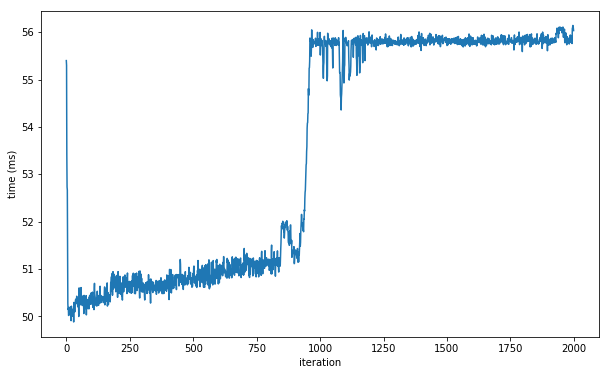

In [46]:
plt.figure(figsize=(10,6))
plt.plot(times[0])
plt.xlabel('iteration')
plt.ylabel('time (ms)');

In [ ]:
plt.figure(figsize=(20,12))
tt = times[0]
# for i in range(len(tt)):
plt.plot(tt)
plt.legend(loc='best')
print(tt.min())

In [ ]:
for i in range(len(times)):
    print(((times[i][1:]-times[i][:-1])<0).sum())

In [12]:
for m in [mobilenet_v2, squeezenet1_0, squeezenet1_1, shufflenet_v2_x1_0]:
    net = m(pretrained=False).cuda(1)
    for b in [8,32]:
        print(type(net).__name__, b, time_net(net, measurements=200, batch_size=b))
        sleep(100)

MobileNetV2 8 6.167173385620117
MobileNetV2 32 20.763635635375977
SqueezeNet 8 5.042076110839844
SqueezeNet 32 17.52185821533203
SqueezeNet 8 3.0138492584228516
SqueezeNet 32 9.826421737670898
ShuffleNetV2 8 7.151365280151367
ShuffleNetV2 32 7.41124153137207


In [16]:
models_paths= [
    (PrunedResnet30, '/home/victoria/Downloads/resnet50_pruned0.3.pth'),
    (PrunedResnet50, '/home/victoria/Downloads/resnet50_pruned0.5.pth'),
    (PrunedResnet70, '/home/victoria/Downloads/resnet50_pruned0.7.pth')
]
for m, p in models_paths:
    net = m().cuda(1)
    net.load_state_dict(torch.load(p))
    for b in [8,32]:
        print(type(net).__name__, b, time_net(net, measurements=100, batch_size=b))
        sleep(200)

PrunedResNet 8 12.661218643188477
PrunedResNet 32 43.511390686035156
PrunedResNet 8 10.451316833496094
PrunedResNet 32 33.727169036865234
PrunedResNet 8 9.839296340942383
PrunedResNet 32 31.76140785217285


In [5]:
180*38*7/3600

13.3

In [14]:
net, _, _ = ResNet_gating(1000)
mapper = ResNetGatesModulesMapper(net.net, False, False)
hyper_edge_to_channels = create_edge_to_channels_map(mapper, net.forward_hooks)
hyper_edge_to_channel_number = {k:v.size(0) for k,v in hyper_edge_to_channels.items()}


original_cost = 76848.00

channels_config = filter_mapping_from_default_resnet(resnet50(False))
orig_resnet = custom_resnet_50(channels_config)
orig_resnet = orig_resnet.cuda(1)


for _ in range(7):
    print("{:2d}, {:8.4f}, {:8.4f}".format(0, 100, time_net(orig_resnet, run_times=1, batch_size=32, measurements=40, sleep_seconds=0)))
    sleep(180)
    for i, (_,ch_num_change) in enumerate(hyper_edge_to_channel_number.items()):
        conv_channels_dict = {}
        ch_num_change = int(ch_num_change * 0.5)
        for j, (hyper_edge, ch_num_keep) in enumerate(hyper_edge_to_channel_number.items()):
            num_channels = hyper_edge_to_channel_number[hyper_edge]
            # take only out channels of convolutions
            num_channels = ch_num_change if i==j else ch_num_keep
            for k, (_, s) in enumerate(hyper_edge.convs_and_sides):
                if not s:
                    dot_string_to_tree_dict(conv_channels_dict, hyper_edge.conv_names[k], num_channels)

        custom_net = custom_resnet_50(conv_channels_dict).cuda(1)
        new_cost, _ = custom_net.compute_flops_memory()
        print("{:2d}, {:8.4f}, {:8.4f}".format(i+1, 100*new_cost/original_cost, time_net(custom_net, run_times=1, batch_size=32, measurements=40, sleep_seconds=0)))
        sleep(180)

/media/victoria/d/projects/gator/models/wrapped_gated_models.py:37: UserWarning: created gating module with 0 weight, make sure you are not training it
  warnings.warn("created gating module with 0 weight, make sure you are not training it")


 0, 100.0000,  49.5400
 1,  97.6369,  48.1954
 2,  98.3344,  49.4068
 3,  97.8347,  49.1486
 4,  97.8347,  49.2971
 5,  97.8347,  49.2303
 6,  97.8347,  49.4194
 7,  97.8347,  49.0959
 8,  94.3369,  44.4860
 9,  98.1678,  47.2078
10,  97.8347,  48.6755
11,  97.8347,  49.2513
12,  97.8347,  49.2074
13,  97.8347,  49.3271
14,  97.8347,  49.1140
15,  97.8347,  49.2806
16,  97.8347,  49.2270
17,  92.3381,  45.3217
18,  98.1678,  48.9736
19,  97.8347,  49.1097
20,  97.8347,  48.7685
21,  97.8347,  49.1083
22,  97.8347,  48.8839
23,  97.8347,  49.2277
24,  97.8347,  48.8763
25,  97.8347,  49.0367
26,  97.8347,  48.8811
27,  97.8347,  49.1121
28,  97.8347,  48.7962
29,  97.8347,  49.1204
30,  89.6731,  45.3324
31,  98.1678,  48.8787
32,  97.8347,  49.2988
33,  97.8347,  49.4521
34,  97.8347,  49.3405
35,  97.8347,  49.4184
36,  97.8347,  49.3603
37,  95.3362,  48.0559
 0, 100.0000,  49.8474
 1,  97.6369,  48.3937
 2,  98.3344,  49.5160
 3,  97.8347,  49.1157
 4,  97.8347,  49.5081
 5,  97.834